In [ ]:
# Import relevant libraries

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader    #dataloader to create multiple batch for training part
import matplotlib.pyplot as plt

In [ ]:
# Set display options; this step is optional

torch.set_printoptions(precision=2, sci_mode=None)
np.set_printoptions(precision=2, suppress=True)

# Set random seed for reproducibility of the results

torch.manual_seed(42) #to assure that the result will be same for multiple run of code and seed value can be anything

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Reading images of a specific category

import os
from PIL import Image

main_folder = "/content/drive/MyDrive/train copy-20240627T163701Z-001/train copy/normal"

# Initialize lists to store images and labels

images = []
labels = []

count = 0

# Loop through each file in the subfolder

for file_name in os.listdir(main_folder):

    if file_name.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # Add more extensions if needed
        image_path = os.path.join(main_folder, file_name)

        with Image.open(image_path) as img:

            img = img.resize((193, 193))
            img = img.convert('L')
            img_array = np.array(img)
            count+=1
            images.append(img_array)
            labels.append(1)

In [ ]:
# Get the dataset description

images = np.asarray(images)
labels = np.asarray(labels)

print("images.shape: \t", images.shape, "\n")
print("labels.shape: \t", labels.shape, "\n")
print("np.unique(labels): \t", np.unique(labels), "\n")
print("Total number of images read: \t", count, "\n")

images.shape: 	 (24, 193, 193) 

labels.shape: 	 (24,) 

np.unique(labels): 	 [1] 

Total number of images read: 	 24 



In [ ]:

import torch

images = torch.from_numpy(images)
labels = torch.from_numpy(labels)

torch.save(images, main_folder+"images.pt")
torch.save(labels, main_folder+"labels.pt")

In [ ]:

images = torch.load("/content/drive/MyDrive/train copy-20240627T163701Z-001/train copy/normalimages.pt")
labels = torch.load("/content/drive/MyDrive/train copy-20240627T163701Z-001/train copy/normallabels.pt")

images = images.resize(images.size()[0], 1, images.size()[1], images.size()[2])
images = images/255.0

print("torch.min(images)", torch.min(images), "\n")
print("torch.max(images)", torch.max(images), "\n")

torch.min(images) tensor(0.) 

torch.max(images) tensor(1.) 



/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:893: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
dataset = TensorDataset(images,labels)
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)

In [ ]:
!pip install torchsummary

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

# Define your ConvVAE model
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # Latent space
        self.fc_mu = nn.Linear(256 * 12 * 12, 64)
        self.fc_logvar = nn.Linear(256 * 12 * 12, 64)

        # Decoder layers
        self.decoder_input = nn.Linear(64, 256 * 12 * 12)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, output_padding=1),  # Adjust output padding
            nn.Sigmoid()  # Ensures output is in [0, 1]
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        z = z.view(z.size(0), 256, 12, 12)  # Adjust to match last encoder layer size
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Initialize the model
model = ConvVAE()
# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model summary
summary(model, (1, 200, 200))  # Assuming input shape is (batch_size, channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]             544
              ReLU-2         [-1, 32, 100, 100]               0
            Conv2d-3           [-1, 64, 50, 50]          32,832
              ReLU-4           [-1, 64, 50, 50]               0
            Conv2d-5          [-1, 128, 25, 25]         131,200
              ReLU-6          [-1, 128, 25, 25]               0
            Conv2d-7          [-1, 256, 12, 12]         524,544
              ReLU-8          [-1, 256, 12, 12]               0
            Linear-9                   [-1, 64]       2,359,360
           Linear-10                   [-1, 64]       2,359,360
           Linear-11                [-1, 36864]       2,396,160
  ConvTranspose2d-12          [-1, 128, 24, 24]         524,416
             ReLU-13          [-1, 128, 24, 24]               0
  ConvTranspose2d-14           [-1, 64,

In [ ]:

vae = ConvVAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Defining the loss function

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:

loss_all_epochs = []

num_epochs = 10
vae.train()

for epoch in range(num_epochs):

    total_loss = 0.0

    for batch_idx, data in enumerate(dataloader):

        features, labels = data[0], data[1]
        features = features.float()
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(features)
        loss = loss_function(recon_batch, features, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    total_loss = round(total_loss,2)
    loss_all_epochs.append(total_loss)

    print("Epoch: \t", epoch+1, "\t Loss: \t", total_loss, "\n")
    print("mu.size(): \t", mu.size(), "\n")
    print("logvar.size(): \t", logvar.size(), "\n\n")

Epoch: 	 1 	 Loss: 	 621529.72 

mu.size(): 	 torch.Size([3, 64]) 

logvar.size(): 	 torch.Size([3, 64]) 


Epoch: 	 2 	 Loss: 	 554136.1 

mu.size(): 	 torch.Size([3, 64]) 

logvar.size(): 	 torch.Size([3, 64]) 


Epoch: 	 3 	 Loss: 	 546835.81 

mu.size(): 	 torch.Size([3, 64]) 

logvar.size(): 	 torch.Size([3, 64]) 


Epoch: 	 4 	 Loss: 	 545969.93 

mu.size(): 	 torch.Size([3, 64]) 

logvar.size(): 	 torch.Size([3, 64]) 


Epoch: 	 5 	 Loss: 	 538974.51 

mu.size(): 	 torch.Size([3, 64]) 

logvar.size(): 	 torch.Size([3, 64]) 


Epoch: 	 6 	 Loss: 	 541838.54 

mu.size(): 	 torch.Size([3, 64]) 

logvar.size(): 	 torch.Size([3, 64]) 


Epoch: 	 7 	 Loss: 	 536014.8 

mu.size(): 	 torch.Size([3, 64]) 

logvar.size(): 	 torch.Size([3, 64]) 


Epoch: 	 8 	 Loss: 	 535956.23 

mu.size(): 	 torch.Size([3, 64]) 

logvar.size(): 	 torch.Size([3, 64]) 


Epoch: 	 9 	 Loss: 	 532920.36 

mu.size(): 	 torch.Size([3, 64]) 

logvar.size(): 	 torch.Size([3, 64]) 


Epoch: 	 10 	 Loss: 	 529208.0

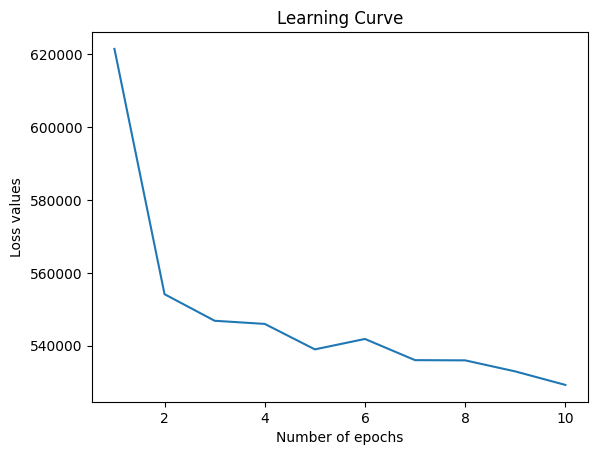

In [ ]:
import matplotlib.pyplot as plt

loss_all_epochs = np.asarray(loss_all_epochs)
epoch_values = np.linspace(1, num_epochs, num_epochs)

plt.plot(epoch_values, loss_all_epochs)
plt.title("Learning Curve")
plt.xlabel("Number of epochs")
plt.ylabel("Loss values")
plt.show()

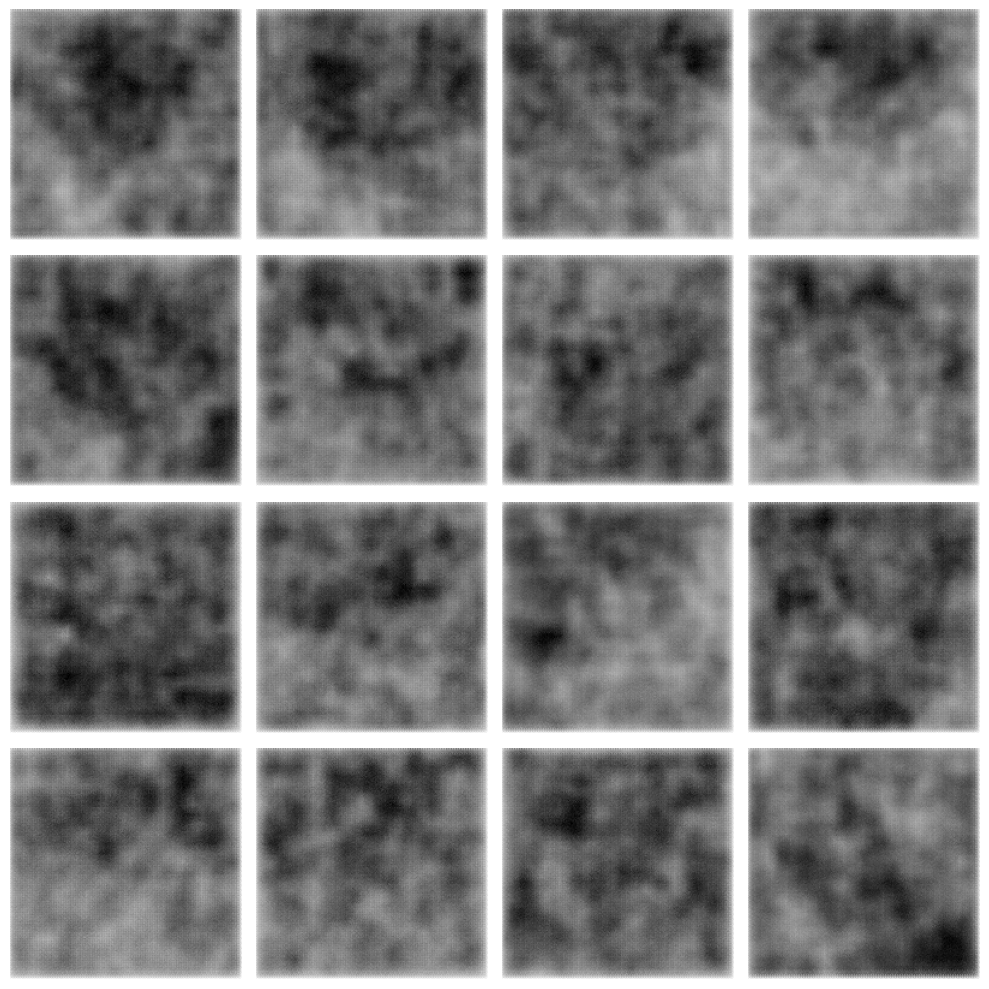

In [ ]:
with torch.no_grad():
    sample = torch.randn(16, 64)  # 16 samples from latent space
    generated_images = vae.decode(sample).cpu()

# Plotting example generated images

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].squeeze().numpy(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()